### Step 1- Camera Calibration

I began by Preparing Objpoints and ImagePoints. The accompanying advances were followed-: 

1. Grayscale the picture 

2. Discover Chessboard Corners. It returns two qualities ret,corners. ret stores whether the corners were returned or not 

3. In the event that the corners were found, annex corners to picture focuses. 

4. I have additionally attracted the chessboard corners to envision the corners 

With this progression we will have the option to get picture focuses and object focuses which will be required to compute the camera alignment and bending coefficients. 

We call the calibrateCamera work which returns us a lot of boundaries, however the ones we are intrigued are the camera network (mtx) and contortion coefficient (dist). 

We at that point utilize the contortion coefficient to undistort our picture.

* From Step 1 we will get the Object Points and Image Points

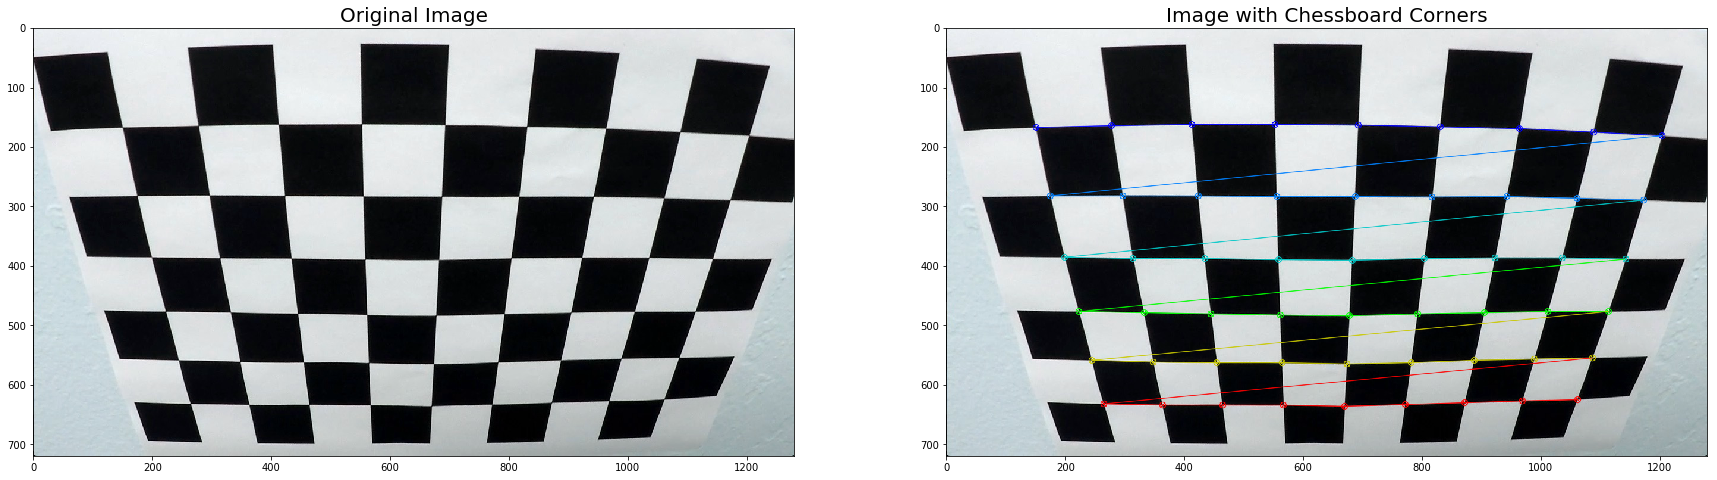

In [35]:
#First thing first

# Step 1- Camera calibration


#Creating an array for object Points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


opoints=[] #real space 3D points 
ipoints=[] #image space 2D points

#list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

f,axes= plt.subplots(1,2,figsize=(30,30))

for i,img in enumerate(images):
    originalImage= cv2.imread(img)
    grayImg= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) #converting to Grayscale before finding Chessboard Corners

    if(i==1):
        # Plotting the original Image
        axes[0].set_title('Original Image', fontsize=20)
        axes[0].imshow(originalImage)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(grayImg, (9,6), None)

    if(ret==True):
        opoints.append(objp)
        ipoints.append(corners)

        # Drawing Chessboard Corners
        cv2.drawChessboardCorners(originalImage, (9,6), corners, ret)
        if(i==1):
            axes[1].set_title('Image with Chessboard Corners', fontsize=20)
            axes[1].imshow(originalImage)

### Step 2- Calculate Undistortion Parameters 

* From Step 2 we will get two parameters- dist(the distortion coefficient), mtx(camera matrix)

Text(0.5,1,'Undistorted Images')

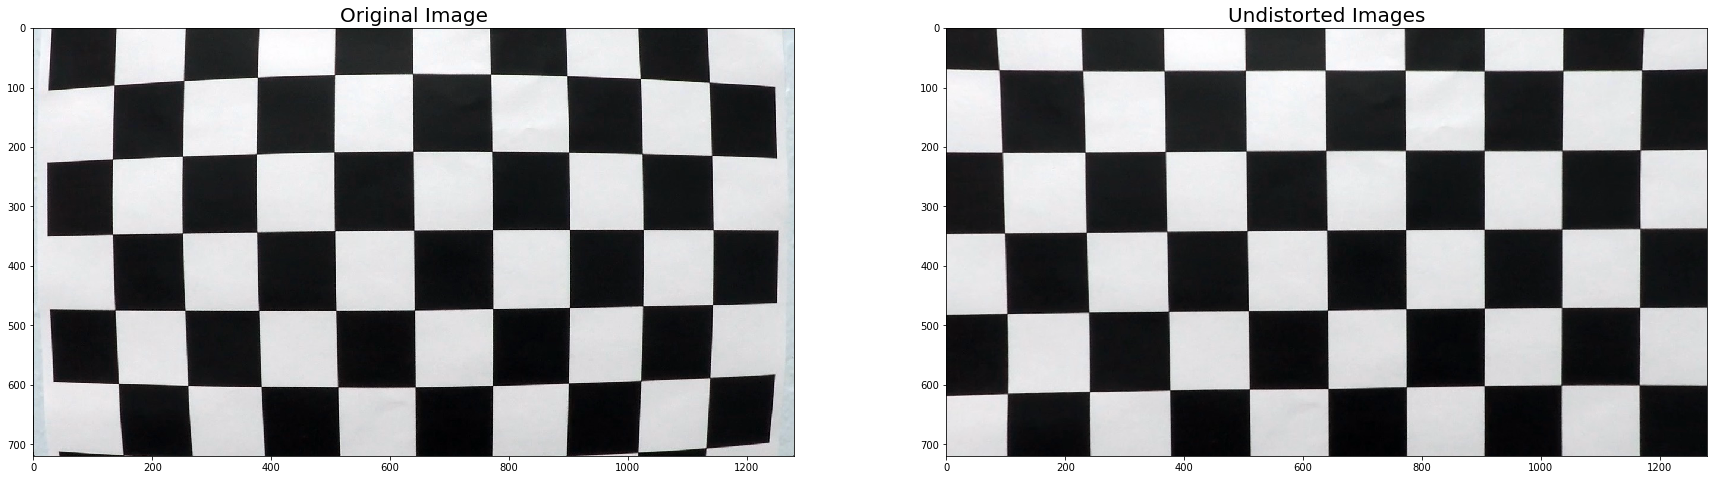

In [36]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(opoints, ipoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

f, axes= plt.subplots(1,2,figsize=(30,30))


axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=20)
axes[1].imshow(dst)
axes[1].set_title("Undistorted Images", fontsize=20)

### Step 3-  Examples of Undistorted Images

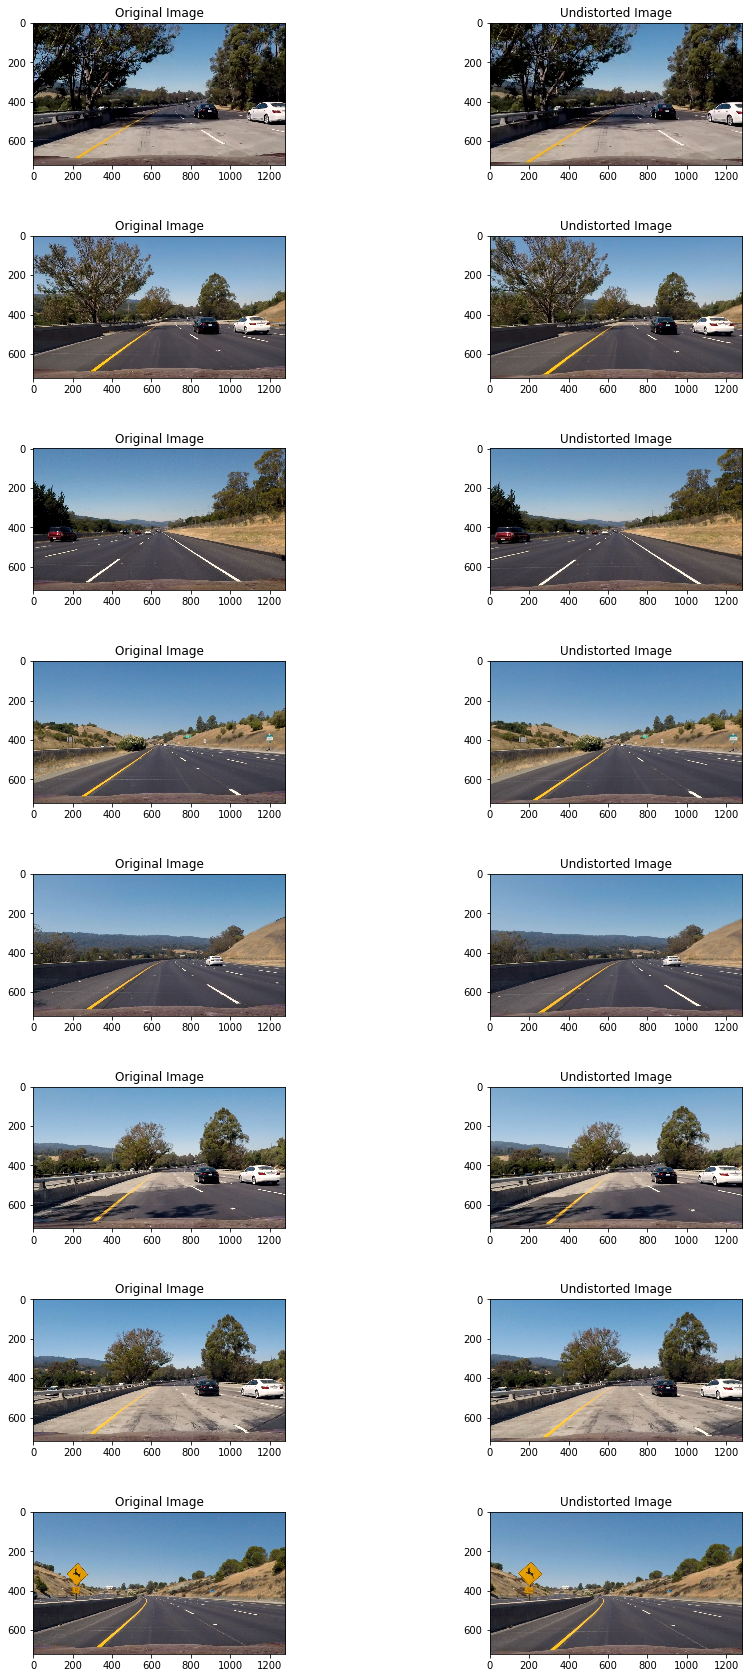

In [37]:
# Step 3- Defining a function to undistort test Images using parameters derived from previous step

## Perspective Transform with Example

In this progression, I initially characterized a Region Of Interest (ROI) for example a Trapezoid with four focuses: 

1. Left Bottom Corner characterized as "left" 

2. Right Bottom Corner characterized as "right" 

3. Left Upper Corner characterized as "apex_left" 

4. Right Upper Corner characterized as "apex_right" 

Subsequent to characterizing the ROI, the following stage is to twist the picture, to see the picture from elevated point of view. 

To do this we have to compute a Matrix with the source and goal focuses. The goal focuses were chosen properly in order to see a decent 10,000 foot point of view. The choice of these focuses depended on hit a preliminary instrument in particular. 

When we get the Matrix we will that alongside Image to CV2 warpPerspective capacity to get the last distorted picture.

### Step 4 and 5- Region of Interest and Warping

In [38]:
# Step 4 and 5- Defining a Region of Interest, Warping an Image from bird's eye view

left=[150,720] #left bottom most point of trapezium
right=[1250,720] #right bottom most point of trapezium
apex_left=[590,450] # left top most point of trapezium
apex_right=[700,450] # right top most point of trapezium

src=np.float32([left,apex_left,apex_right,right]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp


def ROI(originalImage):
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)

def WarpPerspective(image):
    y=image.shape[0]
    x=image.shape[1]
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (x,y), flags=cv2.INTER_LINEAR)

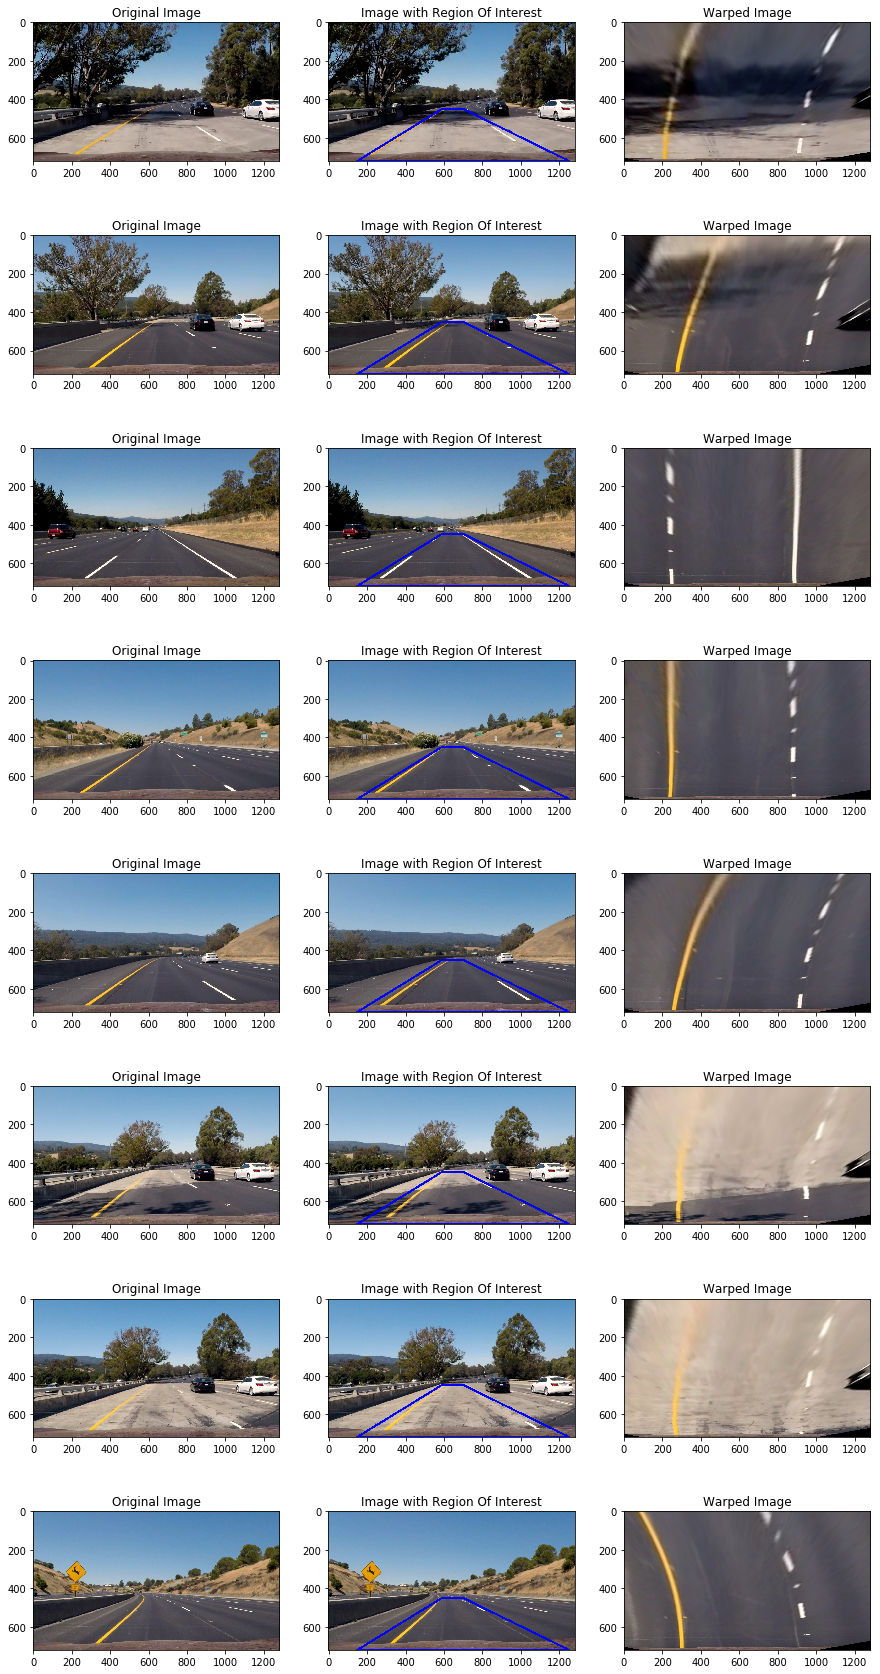

In [39]:
# Testing Region of Interest and Wrap on Test Images

### Step 6- Color Space Tranformarion with example

According to Udacity's proposal, I attempted a different number of colorspaces to get a decent twofold picture in all lighting conditions. I attempted the accompanying shading Spaces-: 

1. HLS 

2. HSV 

3. LAB 

4. YUV 

5. YCrCb 

I characterized a typical capacity to remove a specific channel from a colorspace. 

Capacity Name-ExtractChannel 

Input

* picture - the distorted picture from which we have to remove 

* colorspace-the cv2 colorspace. Ex-cv2.COLOR_RGB2HSV 

* edge the limit estimation of pixels which should be chosen so as to get the twofold picture. [min_threshold, max_threshold] 

* channel-the channel we have to separate from the picture 

Output

* Paired Image with the necessary channel and edge esteems applied


Text(0.5,1,'Cb - Blue Differnce')

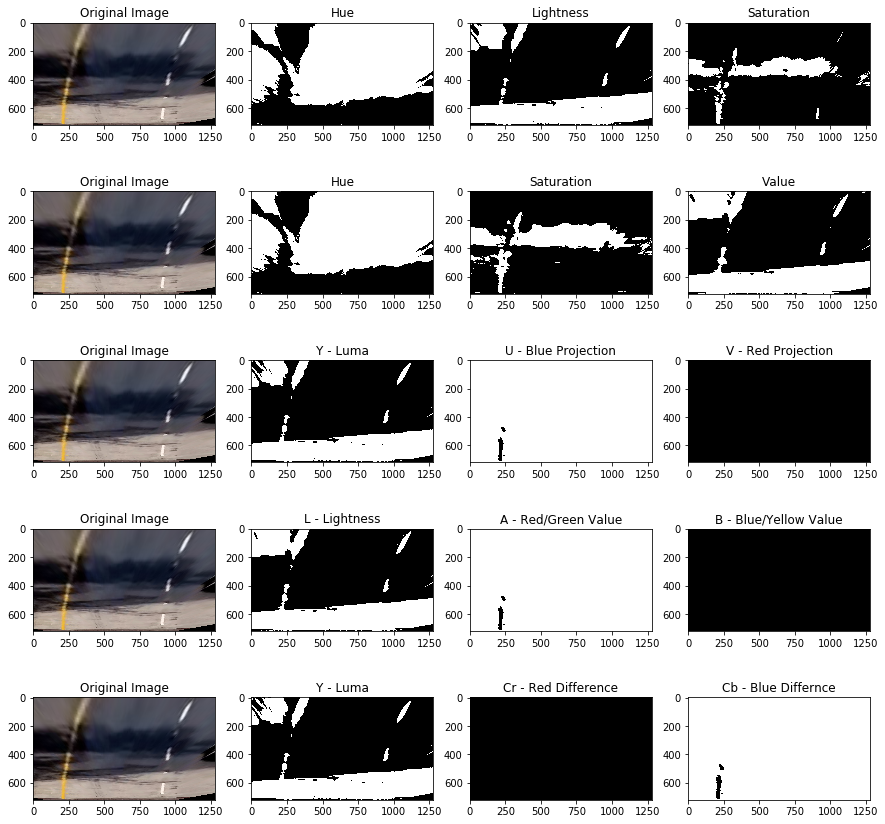

In [40]:
# Step 6- Selecting a Color Space

def ExtractChannel(image,colorspace,threshold,channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    extracted_channel = colorspace[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary

### Step 7 - Sobel with example

I characterized a typical capacity to apply sobel. 

Capacity Name-Sobel 

Information 

* warpedimage-the first twisted picture 

* limit the edge that will be applied to choose the pixel esteems 

* sobelType-the bearing where we have to take the slope. values-x-for x slope , y-for y inclination, xy for supreme and dir for bearing 

* kernelSize-the size of the portion 

Yield Binary Image with the necessary limits , sobelType and kernelSize

In [10]:
# Step 7- Applying Sobel to warped image

def Sobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    arctan= np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobelType=='x'):
        valParam=abs_sobelx
    elif(sobelType=='y'):
        valParam= abs_sobely
    elif(sobelType=='xy'):
        valParam= grad
    else:
        valParam=arctan
        
    
    img = np.uint8((valParam* 255)/np.max(valParam)) # Creating a normalized sobel image
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

Text(0.5,1,'Sobel Direction')

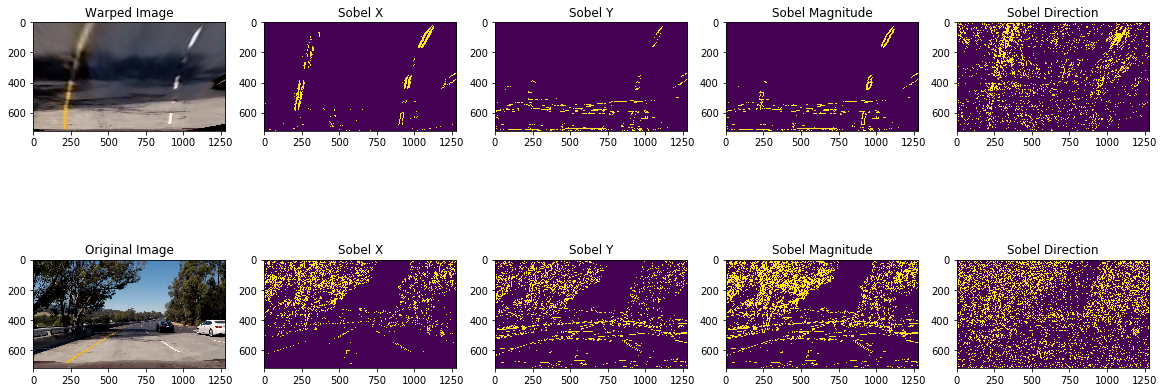

In [11]:
# testing sobel on test_image and warped image

## Combination of Color Transform and Gradients with example

The decision of choice of the shading spaces were arbitrary yet with a reason. I chose to utilize Saturation channel of HLS since it works kind of well under all conditions. Be that as it may, that was insufficient as it couldn't produce lines for specked white lines. I saw that the Lightness direct HLS functions admirably in all the conditions with the exception of the situation when the picture is excessively splendid. I chose to utilize and of both Saturation and Lightness Channel. Be that as it may, I was not even content with that as some black out edges were as yet not identified so I chose to utilize another luminance channel, this time from YUV colorspace-the Y channel. 

When I was finished with choosing the shading space the following stage was to choose the Gradient I needed to apply. As should have been obvious clear vertical edges utilizing the x slope, I chose to utilize X angle as it were. 

Last Combination- 

1. Blend Channel 1 = Saturation Channel and Lightness Channel from HLS 

2. Blend Channel 2 = Mix Channel 1 and Y channel for YUV 

3. Last Combination= Mix Channel 2 or Sobel Gradient in X direction


In [12]:
# Step 8- Combining Different ColorSpaces and Sobel Variants

def combineEverything(warpedImage, color_threshold, sobel_threshold):
    
    s_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,2)
    l_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,1)
    y_channel= ExtractChannel(warpedImage,cv2.COLOR_RGB2YUV,color_threshold,0)
    
    sobelx = Sobel(warpedImage, sobel_threshold, 'x')
    sobeldir= Sobel(warpedImage, [0.7,25], 'dir')
    #sobelxy=Sobel(warpedImage, sobel_threshold, 'xy')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

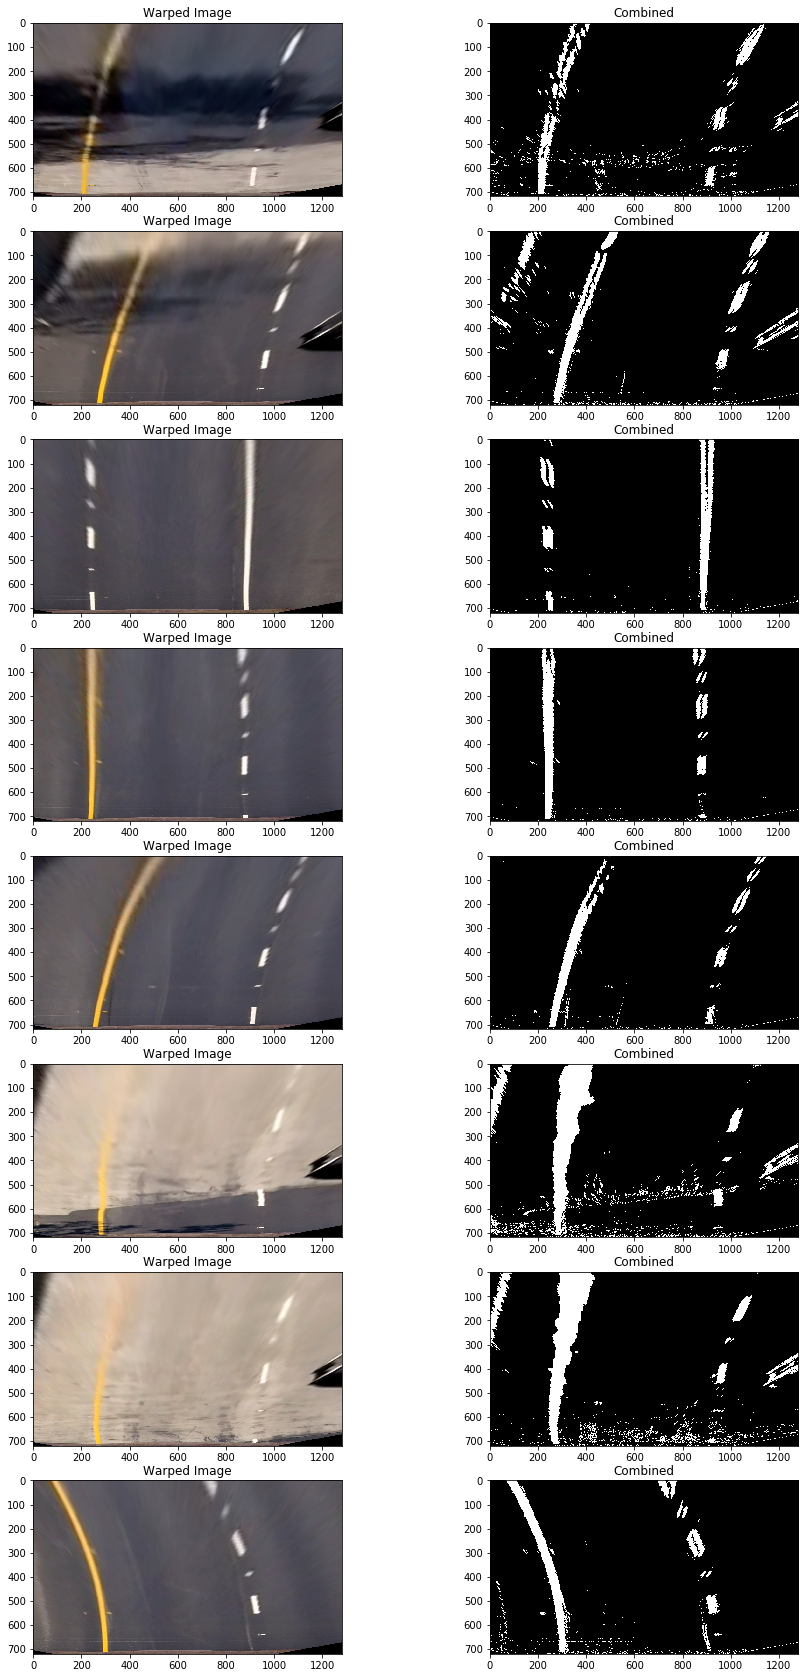

In [13]:
#testing on test_images

## Identifying lane-line pixels with Example

The first step is to create a Histogram of lower half of the image. With this way we are able to find out a distinction between the left lane pixels and right lane pixels.

In [14]:
# Step 9 Plotting Histogram

def Histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)

Text(0.5,1,'Histogram')

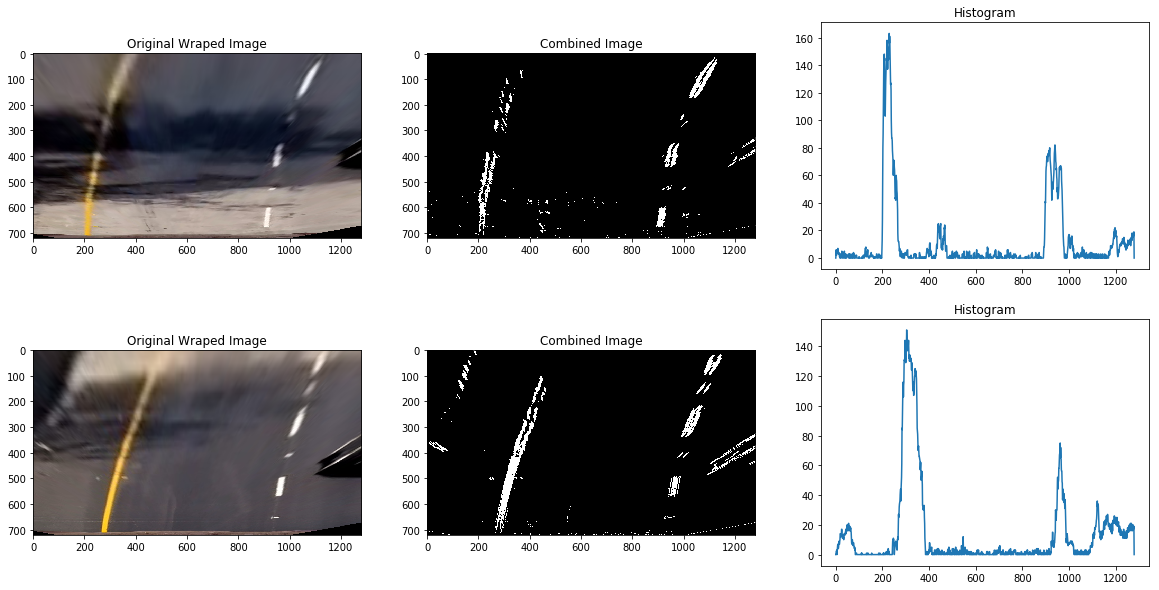

In [15]:
# testing it on test images

The following stage is to start a Sliding Window Search in the left and right parts which we got from the histogram. 

The sliding window is applied in following advances: 

1. The left and right base focuses are determined from the histogram 

2. We at that point figure the situation of all non zero x and non zero y pixels. 

3. We at that point Start emphasizing over the windows where we start from focuses compute in point 1. 

4. We at that point distinguish the non zero pixels in the window we simply characterized 

5. We at that point gather all the lists in the rundown and choose the focal point of next window utilizing these focuses 

6. When we are done, we seperate the focuses to left and right positions 

7. We at that point fit a second degree polynomial utilizing np.polyfit and point ascertain in sync 

In [16]:
# Step 10- Sliding Window Search
def SlidingWindowSearch(binary_warped, plot=False):

    histogram = Histogram(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

  

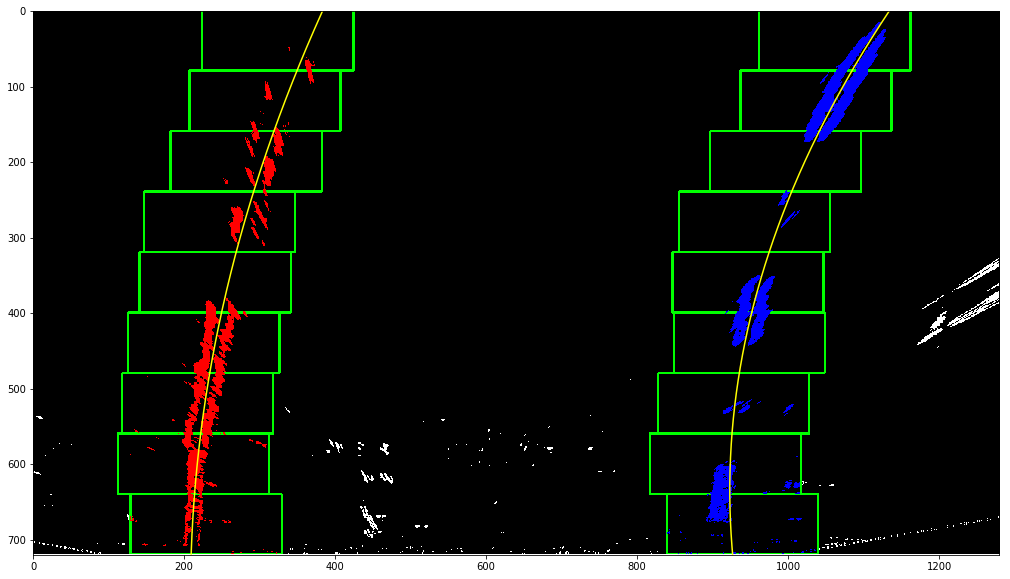

In [17]:
# Draw Sliding Window Visualization

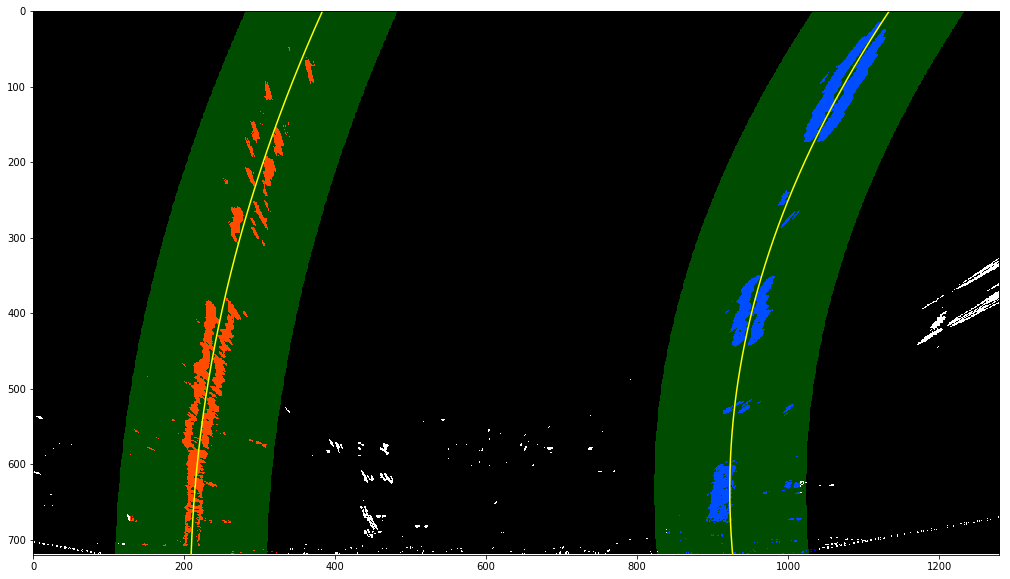

In [18]:
# Visualizing Smoothly

## Radius of Curvature and Distance from Center Calculation 


To compute Radius-: 

1. First we characterize qualities to change over pixels to meters 

2. Plot the left and right lines 

3. Compute the ebb and flow from left and right paths seperately 

4. Return mean of qualities determined in sync 3. 

For Distance-: 

We realize that the focal point of picture is the focal point of the vehicle. To ascertain the deviation from the middle, we can watch the pixel positions in the left path and the correct path. We take the mean of the left base most purpose of the left path and right base most purpose of the correct path and afterward take away it from the focal point of the vehicle to get the deviation from the inside.

In [21]:
def CalculateRadiusOfCurvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2, distance
    # Example values: 632.1 m    626.2 m

## Image Plotted Back with Example

When we are finished with this the subsequent stage is to unwarp the picture back to unique picture. To do so following advances were followed-: 

1. Recast the x and y point to give as contribution to cv2.fillPoly. These are similar focuses we got from fitting the lines. 

2. Ascertain the Minv which is Inverse Matrix. This is finished by passing the opposite focuses this chance to getPerspectiveTransform work 

3. Draw the sidelines from the focuses chose in sync 1 onto a clear twisted picture 

4. Unwarp the picture utilizing cv2.warpPerspective. 

5. Consolidate the first picture with the picture we got from stage 4 to plot the path lines.

In [19]:
# Unwarp Image and plot line

def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

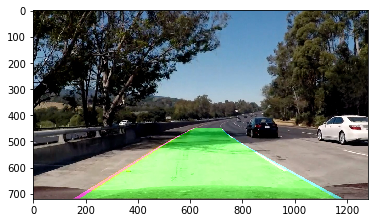

In [20]:
# testing it on test image

### Defining Pipeline

In [22]:
from random import randint
import datetime
import time
def pipeline(originalImage):
    originalImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    undistortedImage= undistortImage(originalImage)
    warpedImage= WarpPerspective(undistortedImage)
    combinedImage= combineEverything(warpedImage,color_threshold= [100,255],sobel_threshold=[10,150])
    returnedOutput =  SlidingWindowSearch(combinedImage)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    #VisualizeSlidingWindow(combinedImage, left_fit,right_fit, returnedOutput[2], returnedOutput[3],returnedOutput[4])
    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
    #cv2.imwrite('./test/'+str(randint(0, 99999))+'.jpg',originalImage)
    
    radius, distance = CalculateRadiusOfCurvature(combinedImage,left_fit,right_fit)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    #print(distance)
    cv2.putText(finalImage,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')
        
    cv2.imwrite('./Output_1/'+str(st)+'.jpg',originalImage)
    
    cv2.imwrite('./Output_1/'+str(st)+'_o.jpg',finalImage)
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))
    finalImage[100:240,1000:1200, :]= cv2.resize(newCombinedImage, (200,140))
    return cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
    

### Running Pipeline on Test Images

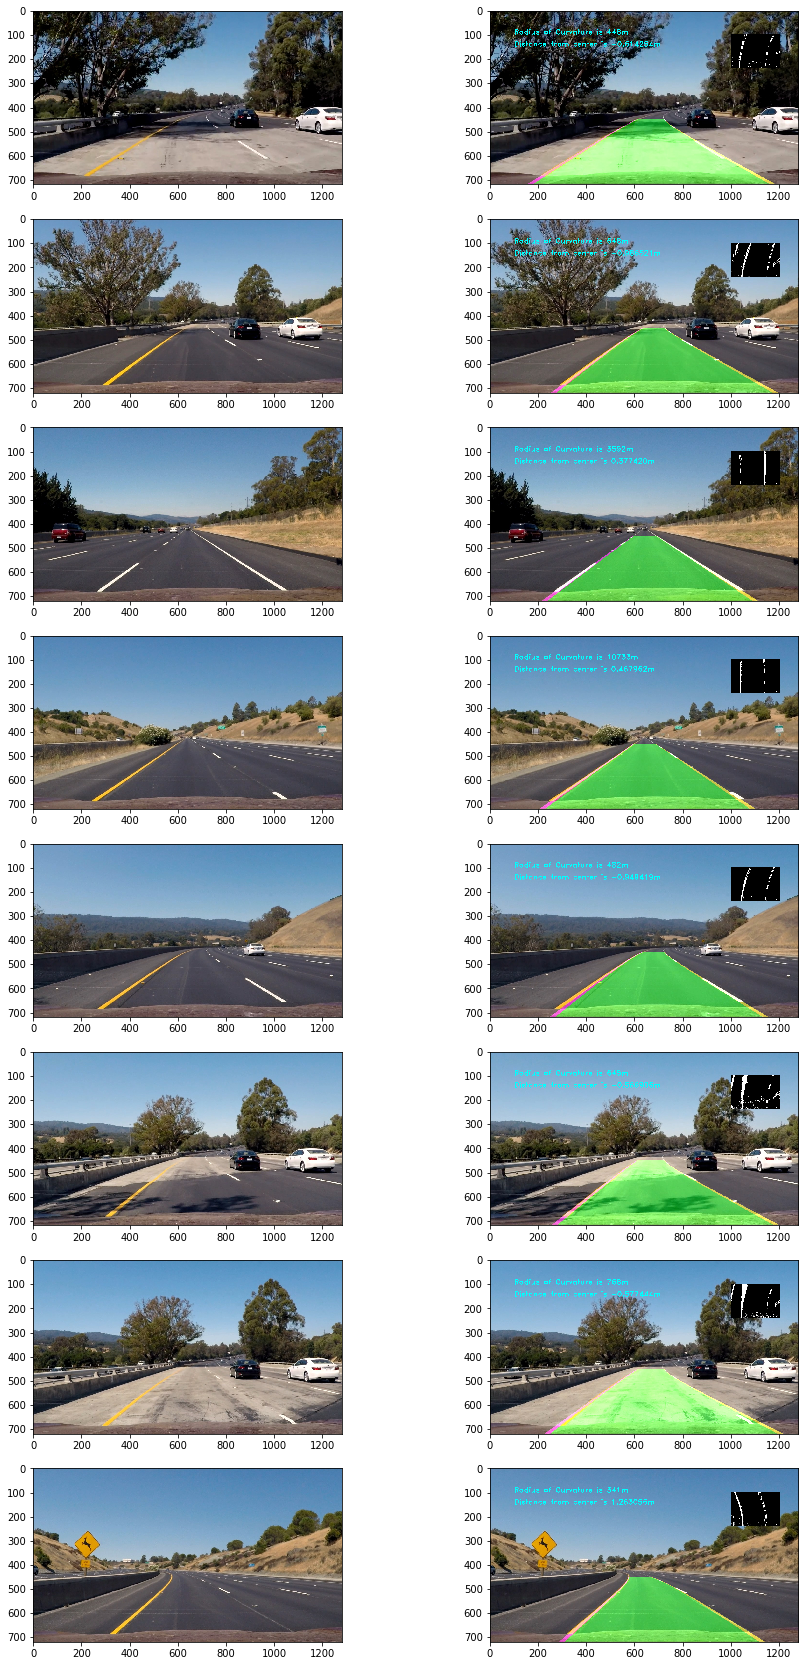

In [23]:
#testing on test images

### Step 15- Running Pipeline on  Test Video

In [27]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 24%|██▍       | 303/1261 [01:45<05:37,  2.84it/s]


 48%|████▊     | 605/1261 [03:34<04:07,  2.65it/s]


 72%|███████▏  | 907/1261 [05:23<02:06,  2.81it/s]


 96%|█████████▌| 1205/1261 [07:13<00:19,  2.84it/s]


100%|█████████▉| 1260/1261 [07:32<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 12s, sys: 1min 14s, total: 5min 27s
Wall time: 7min 35s


In [2]:
from IPython.display import HTML
video_out="project_video_output.mp4"
HTML("""<video width="480" height="270" controls><source src="{0}">
</video>""".format(video_out))

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

The main issue is to locate the right source and goal focuses. It is a hit and preliminary methodology and even 5 pixels all over can have a major effect. The subsequent issue is the point at which I was attempting to utilize different blends of shading channels the last mix didn't work in practically all conditions. It was again by hit and preliminary I made sense of awful casings and checked my pipleline and made changes to as well as administrators and limits. The following test and the most serious issue is to quit flashing of path lines on solid surface or when the vehicle comes out from the shadow. 

I gave my pipeline a shot the test video and I saw it fizzled. So I will explore different avenues regarding the test video without a doubt. It is very conceivable that left path line to focus is of various shading and from focus to right path is of various shading as in the test video and it is probably going to come up short there. Likewise if there should arise an occurrence of a mountain landscape, it is very prone to fall flat. 

To make it progressively powerful and stop the flashing of path lines, we can average out the focuses from the past casings to have a smooth change for each edge.